In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/home/bread/fastai/")

from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

from scipy.misc import imsave

import json
import pandas as pd
import os

/home/bread/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('/home/bread/data/salt')
TRAIN_DN = 'images128'
MASKS_DN = 'masks128'
TEST_DN = 'test128'

train_csv = pd.read_csv(PATH/'train.csv')

In [5]:
sz = 128
bs = 32
nw = 16

In [6]:
# # This implementation of Unet requires the image input size to be a multiple of 32

# # Using skimage breaks fastai environment
# from skimage.transform import resize
# img_size_ori = 101
# img_size_target = 128

# def upsample(img):
#     if img_size_ori == img_size_target:
#         return img
#     return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
# def downsample(img):
#     if img_size_ori == img_size_target:
#         return img
#     return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [7]:
# # Script to upsample train/test images

# dirs = [('test128', TEST_DN), ('train128', TRAIN_DN)]
# for (d128, d) in dirs:
#     for fn in os.listdir(PATH/d):
#         im = imageio.imread(PATH/d/fn)
#         up_im = upsample(im)
#         imageio.imwrite(PATH/d128/fn, up_im)

In [8]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

# Dataset setup

In [9]:
# Custom dataset for input/mask pairs

class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [10]:
# Arrays of filenames for dataset
x_names = np.array([Path(TRAIN_DN)/(o+'.png') for o in train_csv['id']])
y_names = np.array([Path(MASKS_DN)/(o+'.png') for o in train_csv['id']])
test_names = np.array([Path(TEST_DN)/o for o in os.listdir(PATH/TEST_DN)])

In [11]:
# Validation split and test set
val_idxs = list(range(400))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
test=(test_names, test_names)

In [12]:
# Data augmentation using fastai API
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
#             RandomDihedral(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [13]:
# Fastai dataset API
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=test, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)

In [14]:
x,y = next(iter(md.trn_dl))
x.shape,y.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 128, 128]))

In [57]:
cut, lr_cut = [np.nan, np.nan]


In [48]:
rn34_ch = [(512, 256), (256, 128), (256, 64), (256, 64)]
dn121_ch = [(1024, 1024), (256, 512), (256, 256), (256, 64)]

In [53]:
rn34_ch[1][1]

128

## U-net model

In [15]:
# f = resnet34 # Pytorch model
f = dn121
cut,lr_cut = model_meta[f] # Layer nums of where to cut off the head, etc.

In [16]:
# Get pretrained convolutional base
# Base acts as the contracting path in Unet architecture
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [17]:
# Similar to IoU metric
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [18]:
# Save activations from contracting path to concatenate to expansive path in Unet
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [19]:
# Neural net module for expansive path in Unet
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p) # Expansive part
        x_p = self.x_conv(x_p) # Further convolution on the activations from contracting part
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [20]:
# Expansive path of Unet
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn # Resnet base
        # Input shape is 512x4x4 after resnet34
        # sfs[0] shape: [64x64x64]
        # sfs[1] shape: [64x32x32]
        # sfs[2] shape: [128x16x16]
        # sfs[3] shape: [256x8x8]
        
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,6,8]] # Saved activations from contracting/resnet part
        
#         self.sfs = [SaveFeatures(rn[i]) for i in [2,5,12,22]] # for VGG16
        self.up1 = UnetBlock(1024,1024,256)
        self.up2 = UnetBlock(256,512,256)
        self.up3 = UnetBlock(256,256,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
#         print(self.sfs[3].features.shape)
#         print(self.sfs[2].features.shape)
#         print(self.sfs[1].features.shape)
#         print(self.sfs[0].features.shape)

        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [21]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [22]:
# Instantiate model
m_base = get_base()[0]
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [23]:
# Instantiate fastai learner
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [24]:
# [o.features.size() for o in m.sfs]

In [25]:
im = md.trn_dl.get_batch([0,1])[0][0]
tensor = V(torch.from_numpy(im).unsqueeze(0).contiguous())

In [26]:
m_base = to_gpu(m_base)

In [27]:
f = resnet34
base_2 = to_gpu(get_base())

In [28]:
base_2

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3)

In [29]:
m_base[8]

_DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (relu1): ReLU(inplace)
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (relu2): ReLU(inplace)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True)
    (relu1): ReLU(inplace)
    (conv1): Conv2d(288, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (relu2): ReLU(inplace)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer3): _DenseLayer(
    (norm1): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True)
    (relu1): ReLU(inplace)
    (conv1): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [30]:
m_base(tensor).shape

torch.Size([1, 1024, 4, 4])

In [31]:
# models.get_layer_groups(False)[1:]

# Training

In [32]:
# Freeze pretrained layers for initial finetuning
learn.freeze_to(1)

 83%|████████▎ | 94/113 [00:09<00:01,  9.90it/s, loss=1.54] 


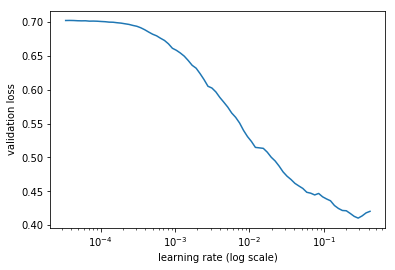

In [33]:
# Fastai function to help find optimal learning rate
# For cyclical learning rate, optimal maximum LR is generally right before the loss diverges in the plot below
learn.lr_find()
learn.sched.plot()

In [34]:
lr=4e-2
wd=1e-7

# "discriminative" learning rates.
# Model is split into layer groups. Theoretically, early layer groups learn simple patterns like edges that
# gerneralize well, therefore should have a smaller learning rate. Larger learning rates are applied to later 
# layer groups that tend to have learned more task-specific behavior
# Try higher learning rates like [lr/9, lr/3, lr]
lrs = np.array([lr/100,lr/10,lr])

In [35]:
# use_clr denotes cyclical learning rate
learn.fit(lrs,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.235998   0.188789   0.922773   0.834262  
    1      0.201021   0.164196   0.933014   0.867635         
    2      0.193861   0.167367   0.936735   0.880445         
    3      0.153966   0.132717   0.940189   0.887791         
    4      0.143149   0.127268   0.942174   0.892555         
    5      0.140161   0.127599   0.938982   0.890623         
    6      0.121698   0.116932   0.935798   0.88138          
    7      0.11477    0.113048   0.945457   0.901328         



[array([0.11305]), 0.9454570007324219, 0.9013283572799001]

In [36]:
learn.save('128urn-tmp')

 73%|███████▎  | 83/113 [00:09<00:03,  9.12it/s, loss=0.203] 


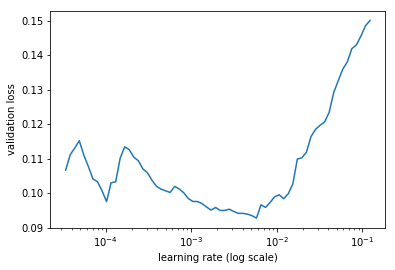

In [37]:
learn.lr_find(wds=1e-7)
learn.sched.plot()

In [38]:
learn.load('128urn-tmp')

In [39]:
learn.unfreeze()
learn.bn_freeze(True)

In [40]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.098868   0.145529   0.940193   0.880188  
    1      0.134103   0.141723   0.935292   0.88012          
    2      0.121262   0.131766   0.939704   0.886086         
    3      0.103607   0.125629   0.945845   0.894768         
    4      0.101515   0.151494   0.936851   0.873669          
    5      0.089333   0.149034   0.93919    0.880991          
    6      0.091252   0.152926   0.939555   0.874679          
    7      0.090245   0.14011    0.940661   0.887043          
    8      0.08355    0.133473   0.94434    0.893254          
    9      0.073678   0.139354   0.943039   0.89448           
    10     0.073227   0.147982   0.938866   0.882002          
    11     0.056194   0.135455   0.94708    0.896629          
    12     0.055065   0.137684   0.944345   0.899012          
    13     0.054348   0.136501   0.939897   0.886629          
    14     0.048367   0.157982   0.945366   0.901099          
   

[array([0.15583]), 0.9455245971679688, 0.900499979897597]

In [41]:
lr=2e-4
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs, 1, wds=wd, cycle_len=5)

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.036023   0.157991   0.945352   0.901286  
    1      0.035476   0.159223   0.944717   0.899787          
    2      0.036008   0.160169   0.944919   0.899826          
    3      0.035023   0.161369   0.945571   0.901084          
    4      0.035933   0.161674   0.945702   0.901268          



[array([0.16167]), 0.9457023620605469, 0.901267751305336]

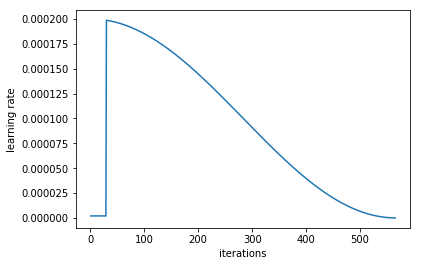

In [42]:
learn.sched.plot_lr()

In [43]:
learn.save('128urn-0')

# Test Predictions

In [44]:
learn.load('128urn-0')

In [45]:
# Make predictions
learn.TTA() # Test time augmentation
preds = learn.predict(is_test=True)
ids = np.array([str(a)[8:-4] for a in md.test_ds.fnames])

In [46]:
np.save(PATH/'preds.npy', preds)
np.save(PATH/'test_ids.npy', ids)

In [47]:
from skimage.transform import resize
preds101 = np.zeros((18000,101,101))
for i in range(len(preds)):
    preds101[i] = downsample(preds[i])

ModuleNotFoundError: No module named 'skimage'

In [ ]:
def myfunc(x):
    if(x > 0):
        return 1
    else:
        return 0
    
vfunc = np.vectorize(myfunc)
predictions = vfunc(preds101)

In [ ]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [ ]:
rle_preds = []
for m in predictions:
    rle_preds.append(rle_encoding(m))
    
rle_str = [' '.join(str(e) for e in rl) for rl in rle_preds]

In [ ]:
sub = pd.DataFrame(np.zeros((18000, 2)), columns=['id', 'rle_mask'])

In [ ]:
ids = [str(a)[8:-4] for a in md.test_ds.fnames]

In [ ]:
sub['id'] = ids
sub['rle_mask'] = rle_str

In [ ]:
sub.to_csv(PATH/'sub2.csv', index=False)